# Imports and file loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import imageio
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
pi=3.14159

In [2]:
file_directory='/home/preston/Desktop/Science/Research/video/'
file_name='microbeads_2.mp4'
ffmpeg_bin='/home/preston/ffmpeg-3.0.2-64bit-static/ffmpeg'

# Clustering

In [3]:
class cluster:
    def __init__(self, cluster_pixels):
        # Trajectory is triplet o
        self._trajectory=np.zeros((0,3))
        self._cluster_pixels=cluster_pixels
        self.calculate_wp()
        self.calculate_hp()
        self.calculate_xp()
        self.calculate_yp()
        self.calculate_xP_yP()
        
    def calculate_wp(self):
        temp_cluster_pixels=self._cluster_pixels[:,1]
        self._wp=int(temp_cluster_pixels.max()-temp_cluster_pixels.min())
        return
    
    def calculate_hp(self):
        temp_cluster_pixels=self._cluster_pixels[:,0]
        self._hp=int(temp_cluster_pixels.max()-temp_cluster_pixels.min())
        return
    
    def calculate_xp(self):
        temp_cluster_pixels=self._cluster_pixels[:,1]
        self._xp=int(temp_cluster_pixels.min()+self._wp/2.)
        return
    
    def calculate_yp(self):
        temp_cluster_pixels=self._cluster_pixels[:,0]
        self._yp=int(temp_cluster_pixels.min()+self._hp/2.)
        return
    
    def calculate_xP_yP(self):
        self._xP=int((self._cluster_pixels[:,1].max()-self._cluster_pixels[:,1].min())/2.+self._cluster_pixels[:,1].min())
        self._yP=int((self._cluster_pixels[:,0].max()-self._cluster_pixels[:,0].min())/2.+self._cluster_pixels[:,0].min())
        self._xP, self._yP = get_pore_coordinates(self._xP, self._yP)

In [4]:
def get_clusters(negative_image, cluster_threshold=5):
    cluster_list=[]
    pixel_check_array=np.ones((negative_image.shape[0], negative_image.shape[1]))
    for i in range(pixel_check_array.shape[0]):
        for j in range(pixel_check_array.shape[1]):
            if pixel_check_array[i,j]==1:
                if negative_image[i,j] >= threshold_difference:
                    cluster_pixels, pixel_check_array=add_pixel_to_cluster\
                    (negative_image, pixel_check_array, i, j, threshold_difference)
                    
                    if cluster_pixels.shape[0]>cluster_threshold:
                        new_cluster=cluster(cluster_pixels)
                        cluster_list.append(new_cluster)
    
    return cluster_list

In [5]:
def add_pixel_to_cluster(image, pixel_check_array, i, j, threshold, cluster_pixels=np.empty((0,2), dtype=int), direction='center'):
    
    cluster_pixels=np.vstack((cluster_pixels,[i,j]))
    pixel_check_array[i,j]=0
    
    # Center (first point)
    if direction == 'center':
        pixel_check_array[i,j]=0
        
    # Right
    if direction != 'right' and j != image.shape[1] -1 and pixel_check_array[i,j+1] == 1:
        if image[i,j+1]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i, j+1, threshold, cluster_pixels, 'left')

    # Below
    if direction != 'below' and i != image.shape[0] - 1 and pixel_check_array[i+1,j] == 1:
        if image[i+1,j]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i+1, j, threshold, cluster_pixels, 'above')   
        
    # Left
    if direction != 'left' and j != 0 and pixel_check_array[i,j-1] == 1:
        if image[i,j-1]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i, j-1, threshold, cluster_pixels, 'right')

    # Above
    if direction != 'above' and i != 0 and pixel_check_array[i-1,j] == 1:
        if image[i-1,j]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i-1, j, threshold, cluster_pixels, 'below')

    return cluster_pixels, pixel_check_array

# Open video connection

In [6]:
vid = imageio.get_reader(file_directory+file_name,  'ffmpeg')
num_frames=vid._meta['nframes']
print num_frames

16224


# Image processing

In [7]:
def preprocess_image(image):
    ystart=50
    yend=225
    xstart=150
    xend=350
    image=rotate(image[ystart:yend, xstart:xend,:], theta, axes=(1,0), reshape=False)
    image=image[40:130, 25:180,:]
    return image

In [8]:
def get_negative_image(image, templage_image):
    negative_image=np.empty((image.shape[0], image.shape[1]), dtype=int)
    for i in range(negative_image.shape[0]):
        for j in range(negative_image.shape[1]):
            negative_image[i,j]=abs(int(image[i,j,0])-int(template_image[i,j,0]))
    return negative_image

In [9]:
def highlight_cluster_pixels(image, cluster_pixels):
    for i in range(cluster_pixels.shape[0]):
        x=cluster_pixels[i,0]
        y=cluster_pixels[i,1]
        image[x,y,0]=image[x,y,0]/10.
        image[x,y,1]=image[x,y,1]*2.
        image[x,y,2]=image[x,y,2]/10.
    return image

# Define template image

In [10]:
def get_pore_coordinates(x, y):
    new_x=(x-xp)*pore_length/pore_plength
    new_y=(y-yp)*pore_width/pore_pwidth
    return new_x, new_y

In [11]:
theta=-3.35
buff=25

pore_pwidth=20.
pore_length=125.
pore_width=25.
pore_plength=107.

xp=25
yp=43

In [12]:
template_frame=0
template_image=vid.get_data(template_frame)
template_image=preprocess_image(template_image)

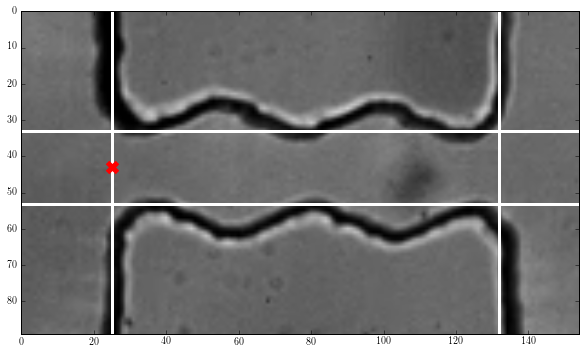

In [13]:
fig=plt.figure(figsize=(10,6))
plt.imshow(template_image)
plt.scatter(xp,yp, s=100, zorder=10, marker='x', c=(1.,0.,0.), lw=5)
plt.plot([xp,xp],[0,1000],lw=3,c=(1.,1.,1.))
plt.plot([xp+pore_plength,xp+pore_plength],[0,1000],lw=3,c=(1.,1.,1.))
plt.plot([0,1000],[yp+pore_pwidth/2,yp+pore_pwidth/2],lw=3,c=(1.,1.,1.))
plt.plot([0,1000],[yp-pore_pwidth/2,yp-pore_pwidth/2],lw=3,c=(1.,1.,1.))

plt.xlim(0,template_image.shape[1]-1)
plt.ylim(template_image.shape[0]-1,0)
plt.show()

# Particle tracking

In [14]:
# Pixel brightness difference threshold for clustering (out of 255)
threshold_difference=20

# Start frame, end frame
start_frame=3000
end_frame=5000

# Frames to skip in between analyzing images
frame_skip=10

# Make video

## Create frame

### Full video

In [15]:
def get_frame(frame):
    # Preprocessing
    image=vid.get_data(frame)
    image=preprocess_image(image)
    negative_image=get_negative_image(image, template_image)
    
    # Find clusters
    new_cluster_list=get_clusters(negative_image)
    clusters_found=len(new_cluster_list)
    
    # Highlight clusters
    for i in range(len(new_cluster_list)):
        image=highlight_cluster_pixels(image,new_cluster_list[i]._cluster_pixels)
    
    # Set cluster text
    for i in range(clusters_found):
        cluster=new_cluster_list[i]
        text='('+str(cluster._wp)+', '+str(cluster._hp)+')'\
        +'\n'+'('+str(round(cluster._xP,2))+', '+str(round(cluster._yP,2))+')'
        particle_text_list[clusters_found-1].set_text(text)
        particle_text_list[clusters_found-1].set_x(cluster._xp)
        particle_text_list[clusters_found-1].set_y(cluster._yp)
                   
    # Remove text from non-visible clusters
    for i in range(clusters_found, len(particle_text_list)):
        particle_text_list[i].set_visible(False)
    
    # Set time text
    time_text.set_text(str(frame)+'/'+str(num_frames))
    
    # Set image array data
    im.set_array(image)
    
    return im, time_text, particle_text_list[0], particle_text_list[1], particle_text_list[2], particle_text_list[3],\
particle_text_list[4]

## Define the figure, axes

In [16]:
time_text_size=16
cluster_text_size=12

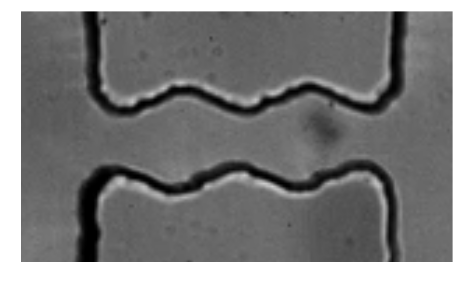

In [17]:
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax = plt.axes(xlim=(0, template_image.shape[1]), ylim=(0, template_image.shape[0]))
im = plt.imshow(template_image)
plt.axis('off')

time_text=ax.text(template_image.shape[1]/2,10,'', size=time_text_size, ha='center')
particle_text_list=[ax.text(0,0,'', size=cluster_text_size, va='center') for i in range(5)]

def init():
    im.set_data(template_image)
    time_text.set_text('')
    return im, time_text

## Create the animation

In [19]:
plt.rcParams['animation.ffmpeg_path']=ffmpeg_bin
anim = animation.FuncAnimation(fig, get_frame, np.arange(num_frames/5, 2*num_frames/5, 1), init_func=init, interval=100, blit=True)
writer=animation.FFMpegWriter()
output_file_name='./'+file_name.split('.')[0]+'_tracking.mp4'
anim.save(output_file_name, writer=writer, fps=60)